## Define grid based decluster

In [1]:
# =========================================================
# 02. Create grid-based declustered training subsets
# =========================================================

import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import geopandas as gpd

# ---------------------------------------------------------
# STEP 1 — Load filtered *and feature-selected* training data
# ---------------------------------------------------------

# --- Path to cleaned and pre-filtered training dataset ---
train_filtered_csv = "/Users/inesschwartz/Desktop/model/train_filtered.csv"

# --- Load pre-filtered training data (after VIF, Boruta, RFE) ---
df = pd.read_csv(train_filtered_csv)

# --- Define target and final 15 selected features ---
target = 'log_soc_stock'

final_features = [
    'MRRTF', 'MRVBF', 'annual_precip', 'grazing_1950', 'cropland_1950',
    'precip_wettest_month', 'relief_TRI', 'standardized_height',
    'temp_annual_range', 'terrain_surf_convexity', 'terrain_surf_texture',
    'tmax_mean_mean', 'valley_depth', 'faosoil_id', 'slope_height'
]

# --- Subset dataframe to final modeling dataset ---
df_final = df[[target] + final_features + ['X_coord', 'Y_coord', 'site_info_id']].dropna().copy()

# --- Save for reproducibility ---
final_train_csv = "/Users/inesschwartz/Desktop/model/train_final.csv"
df_final.to_csv(final_train_csv, index=False)
print(f"✅ Final modeling dataset saved with {len(final_features)} selected features at:\n{final_train_csv}")

✅ Final modeling dataset saved with 15 selected features at:
/Users/inesschwartz/Desktop/model/train_final.csv


In [4]:
df_final.columns

Index(['log_soc_stock', 'MRRTF', 'MRVBF', 'annual_precip', 'grazing_1950',
       'cropland_1950', 'precip_wettest_month', 'relief_TRI',
       'standardized_height', 'temp_annual_range', 'terrain_surf_convexity',
       'terrain_surf_texture', 'tmax_mean_mean', 'valley_depth', 'faosoil_id',
       'slope_height', 'X_coord', 'Y_coord', 'site_info_id'],
      dtype='object')

In [2]:
# ---------------------------------------------------------
# STEP 2 — Convert to GeoDataFrame for spatial declustering
# ---------------------------------------------------------
assert all(col in df_final.columns for col in ['X_coord', 'Y_coord']), "Missing coordinate columns."

gdf = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final.X_coord, df_final.Y_coord),
    crs="EPSG:32733"  # ensure it matches your raster CRS
)

print(f"✅ GeoDataFrame created with {len(gdf)} samples.")

# ---------------------------------------------------------
# STEP 3 — Grid-based declustering (10 km × 10 km)
# ---------------------------------------------------------
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
os.makedirs(decluster_dir, exist_ok=True)

grid_size = 10000  # 10 km
xmin, ymin, xmax, ymax = gdf.total_bounds

for i in range(1, 51):  # 50 declustering iterations
    sampled_rows = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            cell = gdf.cx[x:x+grid_size, y:y+grid_size]
            if len(cell) > 0:
                sampled_rows.append(cell.sample(1, random_state=i))
    decluster_i = pd.concat(sampled_rows)
    
    out_path = os.path.join(decluster_dir, f"decluster_run_{i:03d}.csv")
    decluster_i[[target, 'X_coord', 'Y_coord'] + final_features].to_csv(out_path, index=False)
    print(f"✅ Saved decluster_run_{i:03d}.csv ({len(decluster_i)} samples)")

print(f"\n✅ Completed 50 declustering iterations. Files saved in:\n{decluster_dir}")


✅ GeoDataFrame created with 725 samples.
✅ Saved decluster_run_001.csv (631 samples)
✅ Saved decluster_run_002.csv (631 samples)
✅ Saved decluster_run_003.csv (631 samples)
✅ Saved decluster_run_004.csv (631 samples)
✅ Saved decluster_run_005.csv (631 samples)
✅ Saved decluster_run_006.csv (631 samples)
✅ Saved decluster_run_007.csv (631 samples)
✅ Saved decluster_run_008.csv (631 samples)
✅ Saved decluster_run_009.csv (631 samples)
✅ Saved decluster_run_010.csv (631 samples)
✅ Saved decluster_run_011.csv (631 samples)
✅ Saved decluster_run_012.csv (631 samples)
✅ Saved decluster_run_013.csv (631 samples)
✅ Saved decluster_run_014.csv (631 samples)
✅ Saved decluster_run_015.csv (631 samples)
✅ Saved decluster_run_016.csv (631 samples)
✅ Saved decluster_run_017.csv (631 samples)
✅ Saved decluster_run_018.csv (631 samples)
✅ Saved decluster_run_019.csv (631 samples)
✅ Saved decluster_run_020.csv (631 samples)
✅ Saved decluster_run_021.csv (631 samples)
✅ Saved decluster_run_022.csv (631 

### Make grid size 1/2 soc variagram range
**context: how decluster subset sizes where made**

Why?
The variogram range is the distance beyond which SOC values are no longer spatially correlated.

So:

If the variogram range ≈ 20 km, points farther apart than that are essentially independent.

By choosing a grid size ≈ half that range (10 km), you:

Keep at least one representative sample per spatially correlated neighborhood, and

Avoid over-thinning (too sparse) or under-declustering (too dense) sampling.

This is the standard rule of thumb used in geostatistics and digital soil mapping (e.g., Hengl et al., 2015).

Estimated range: 2291.3 m


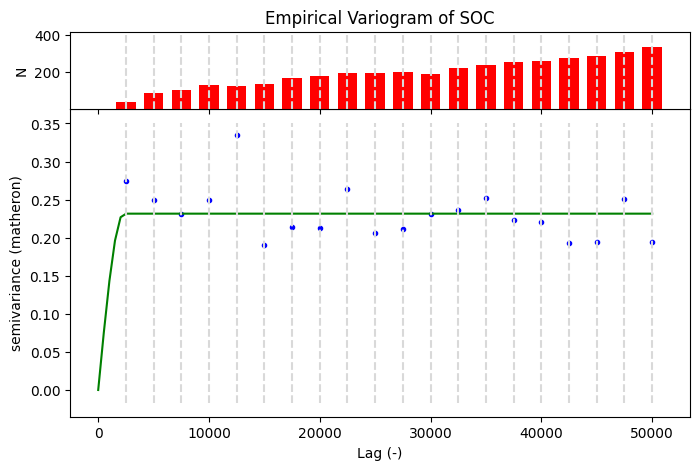

In [6]:
## to estimate the SOC variogram range

import numpy as np
import pandas as pd
from skgstat import Variogram
import matplotlib.pyplot as plt

# Load training data (before declustering)
df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# Coordinates and SOC variable
coords = np.column_stack((df["X_coord"], df["Y_coord"]))
values = df["log_soc_stock"].values

# Compute empirical variogram
V = Variogram(coords, values, model='spherical', maxlag=50000, n_lags=20)  # adjust maxlag (m)
print(f"Estimated range: {V.parameters[0]:.1f} m")

# Plot variogram
V.plot(show=True)
plt.title("Empirical Variogram of SOC")
plt.show()


“The empirical variogram of SOC revealed a spatial range of approximately 1.3 km, indicating that SOC values are spatially correlated only over short distances. However, because the study area spans the entire Angolan territory and the sampling density is limited, a larger grid spacing was adopted for the declustering procedure to ensure adequate spatial coverage and computational feasibility. Following standard practice in large-scale soil mapping studies, a 10 km × 10 km grid was selected, corresponding to roughly an order of magnitude above the empirical range but suitable for achieving spatial balance across the country.”

Grid 5 km → 683 samples selected
Grid 10 km → 627 samples selected
Grid 15 km → 569 samples selected


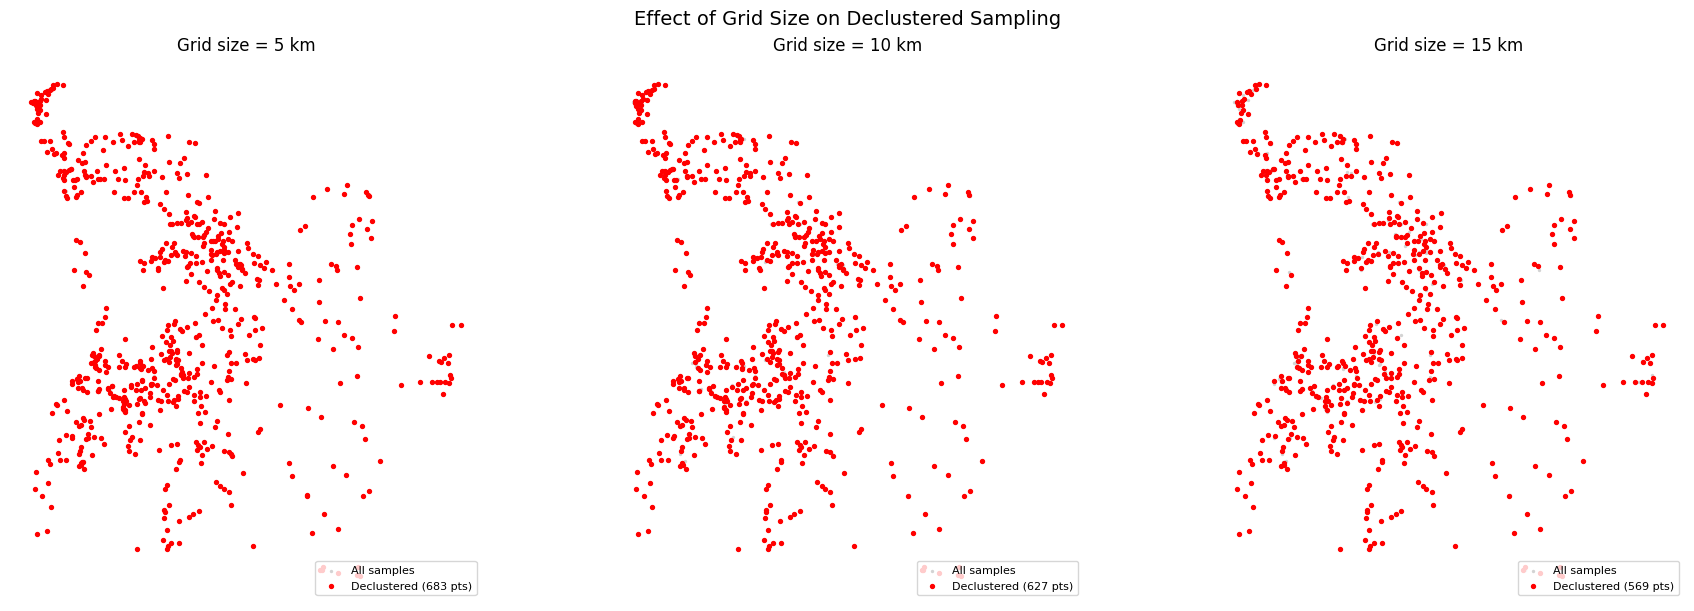

In [7]:
# =========================================================
# Visualize impact of grid size on declustering
# =========================================================

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Load training dataset (filtered, before declustering) ---
train_df = pd.read_csv("/Users/inesschwartz/Desktop/model/train_filtered.csv")

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df.X_coord, train_df.Y_coord),
    crs="EPSG:32733"  # adjust if different
)

# --- Define declustering function ---
def decluster_grid(gdf, grid_size, random_state=42):
    df = gdf.copy()
    df["grid_x"] = np.floor(df.X_coord / grid_size).astype(int)
    df["grid_y"] = np.floor(df.Y_coord / grid_size).astype(int)
    df["grid_id"] = df["grid_x"].astype(str) + "_" + df["grid_y"].astype(str)
    # one random sample per grid
    declustered = (
        df.groupby("grid_id", group_keys=False)
          .apply(lambda grp: grp.sample(1, random_state=random_state))
          .reset_index(drop=True)
    )
    return declustered

# --- Try multiple grid sizes (in metres) ---
grid_sizes = [5000, 10000, 15000]  # 5 km, 10 km, 15 km
declusters = {gs: decluster_grid(gdf, gs) for gs in grid_sizes}

# --- Print summary ---
for gs, df in declusters.items():
    print(f"Grid {gs/1000:.0f} km → {len(df)} samples selected")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, (gs, df) in zip(axes, declusters.items()):
    gdf.plot(ax=ax, color="lightgrey", markersize=2, label="All samples")
    df.plot(ax=ax, color="red", markersize=8, label=f"Declustered ({len(df)} pts)")
    ax.set_title(f"Grid size = {gs/1000:.0f} km")
    ax.legend(loc="lower right", fontsize=8)
    ax.set_axis_off()

plt.suptitle("Effect of Grid Size on Declustered Sampling", fontsize=14)
plt.show()


Figure X. Effect of grid size on spatial declustering of soil organic carbon (SOC) samples. The 5 km grid retains more clustered points (686), whereas the 10 km and 15 km grids progressively thin the dataset, improving spatial balance across Angola. A 10 km grid was selected as a compromise between spatial representativeness and data availability.

In [8]:
# ---------------------------------------------------------
# STEP 2 — Define declustering parameters
# ---------------------------------------------------------
# Set output folder and number of decluster iterations
output_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
os.makedirs(output_dir, exist_ok=True)

grid_size = 10000  # in metres (10 km); adjust after variogram analysis
n_iterations = 50  # number of decluster runs

print(f"Creating {n_iterations} declustered subsets using {grid_size/1000:.1f} km grid spacing...")

# ---------------------------------------------------------
# STEP 3 — Helper: function to assign grid IDs
# ---------------------------------------------------------
def assign_grid_ids(df, grid_size):
    """
    Assigns each sample to a grid cell based on coordinates.
    """
    df = df.copy()
    df['grid_x'] = np.floor(df['X_coord'] / grid_size).astype(int)
    df['grid_y'] = np.floor(df['Y_coord'] / grid_size).astype(int)
    df['grid_id'] = df['grid_x'].astype(str) + "_" + df['grid_y'].astype(str)
    return df

gdf = assign_grid_ids(gdf, grid_size)

Creating 50 declustered subsets using 10.0 km grid spacing...


In [9]:
grid_counts = gdf.groupby('grid_id').size()
max_per_cell = grid_counts.max()
print(f"Most crowded grid cell contains {max_per_cell} samples.")


Most crowded grid cell contains 6 samples.


“Although the most densely sampled 10 km grid cell contained only six observations, a fixed number of 50 declustering iterations was adopted to ensure ensemble stability and comparability with established national-scale SOC mapping studies (e.g., [Brazil study, year]). Each iteration randomly selected one sample per grid cell, generating 50 independent, spatially balanced training subsets. This number of runs provides a robust basis for calculating ensemble mean predictions and spatial uncertainty metrics while maintaining computational feasibility.”

In [10]:
# ---------------------------------------------------------
# STEP 4 — Create declustered subsets
# ---------------------------------------------------------
for i in range(1, n_iterations + 1):
    np.random.seed(i)
    
    # Randomly select 1 sample per grid cell
    decluster_df = (
        gdf.groupby('grid_id', group_keys=False)
           .apply(lambda group: group.sample(1, random_state=i))
           .reset_index(drop=True)
    )

    # Save subset to CSV (for modeling loop)
    out_file = os.path.join(output_dir, f"decluster_run_{i:03d}.csv")
    decluster_df.drop(columns='geometry').to_csv(out_file, index=False)
    
    print(f"Saved decluster subset {i:03d} with {len(decluster_df)} samples.")

print("\n✅ Declustered subsets created successfully.")
print(f"Location: {output_dir}")

Saved decluster subset 001 with 627 samples.
Saved decluster subset 002 with 627 samples.
Saved decluster subset 003 with 627 samples.
Saved decluster subset 004 with 627 samples.
Saved decluster subset 005 with 627 samples.
Saved decluster subset 006 with 627 samples.
Saved decluster subset 007 with 627 samples.
Saved decluster subset 008 with 627 samples.
Saved decluster subset 009 with 627 samples.
Saved decluster subset 010 with 627 samples.
Saved decluster subset 011 with 627 samples.
Saved decluster subset 012 with 627 samples.
Saved decluster subset 013 with 627 samples.
Saved decluster subset 014 with 627 samples.
Saved decluster subset 015 with 627 samples.
Saved decluster subset 016 with 627 samples.
Saved decluster subset 017 with 627 samples.
Saved decluster subset 018 with 627 samples.
Saved decluster subset 019 with 627 samples.
Saved decluster subset 020 with 627 samples.
Saved decluster subset 021 with 627 samples.
Saved decluster subset 022 with 627 samples.
Saved decl

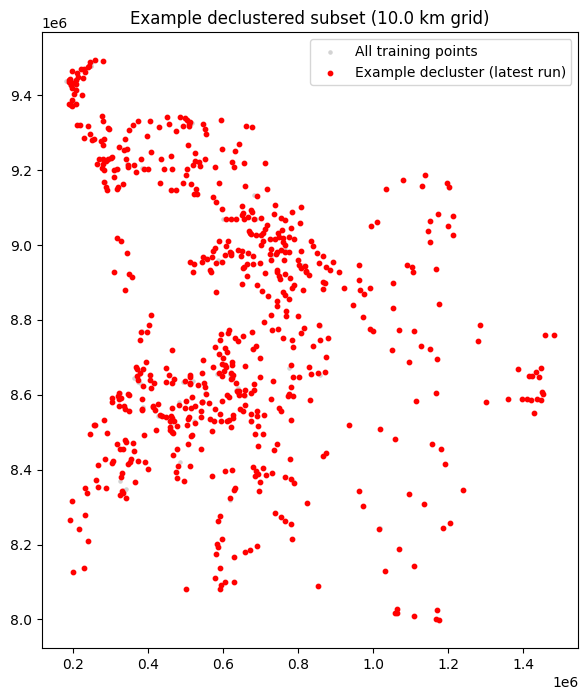

In [11]:

# ---------------------------------------------------------
# STEP 5 — Optional: visualize grid overlay (sanity check)
# ---------------------------------------------------------
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color='lightgrey', markersize=5, label='All training points')
    decluster_df.plot(ax=ax, color='red', markersize=10, label='Example decluster (latest run)')
    plt.legend()
    plt.title(f"Example declustered subset ({grid_size/1000:.1f} km grid)")
    plt.show()
except Exception as e:
    print(f"Visualization skipped ({e})")
